In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.mixed_precision import set_global_policy, Policy

from sklearn.utils import class_weight

In [28]:
# Parameters
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
FINE_TUNE_LEARNING_RATE = 1e-5
train_dir = '../../data5/train'
test_dir = '../../data5/test'

# Enable mixed precision for faster training
policy = Policy('mixed_float16')
set_global_policy(policy)

# Create data generators with VGG16-specific preprocessing
# 2. Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Using the test set as "validation_data" (not ideal practice)
# but shown here due to the 2-folder constraint:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())

print("Number of classes:", num_classes)
print("Class labels:", class_labels)
# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Number of classes: 4
Class labels: ['Acne', 'Eczema', 'Infection', 'Malignant']


In [29]:
# 1) Load VGG16 pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# 2) Decide how many layers to freeze
#    VGG16 has 19 layers (if you count the major layers).
#    We'll freeze the first 20 layers and unfreeze the rest.
# Freeze the initial layers
for layer in base_model.layers[:20]:
    layer.trainable = False

# 3) Build a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dropout(0.5)(x)  
predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 299, 299, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 299, 299, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 149, 149, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 149, 149, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 149, 149, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 74, 74, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/10


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 2738s 15s/step - accuracy: 0.2577 - loss: 4.0373 - val_accuracy: 0.3059 - val_loss: 2.2626 - learning_rate: 1.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2641s 14s/step - accuracy: 0.3000 - loss: 3.2662 - val_accuracy: 0.3998 - val_loss: 1.8088 - learning_rate: 1.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2606s 14s/step - accuracy: 0.3472 - loss: 2.7495 - val_accuracy: 0.4771 - val_loss: 1.5436 - learning_rate: 1.0000e-04
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2627s 14s/step - accuracy: 0.3956 - loss: 2.3496 - val_accuracy: 0.5330 - val_loss: 1.3790 - learning_rate: 1.0000e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2633s 14s/step - accuracy: 0.4473 - loss: 2.0587 - val_accuracy: 0.5664 - val_loss: 1.2868 - learning_rate: 1.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2331s 12s/step - accuracy: 0.4417 - loss: 2.0350 - val_accuracy: 0.5978 - val_loss: 1.2104 - learning_rate: 1.0000e-04
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1508s 8s/step - a

In [31]:
for layer in base_model.layers[:10]:
    layer.trainable = False
for layer in base_model.layers[10:]:
    layer.trainable = True
model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-Tune the Model
history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1878s 10s/step - accuracy: 0.5873 - loss: 1.0676 - val_accuracy: 0.7050 - val_loss: 0.7274 - learning_rate: 1.0000e-05
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1885s 10s/step - accuracy: 0.6865 - loss: 0.7652 - val_accuracy: 0.7321 - val_loss: 0.6703 - learning_rate: 1.0000e-05
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1980s 11s/step - accuracy: 0.7285 - loss: 0.6669 - val_accuracy: 0.7519 - val_loss: 0.6463 - learning_rate: 1.0000e-05
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3635s 19s/step - accuracy: 0.7582 - loss: 0.6140 - val_accuracy: 0.7655 - val_loss: 0.5981 - learning_rate: 1.0000e-05
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3687s 20s/step - accuracy: 0.7712 - loss: 0.5707 - val_accuracy: 0.7783 - val_loss: 0.5649 - learning_rate: 1.0000e-05
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3706s 20s/step - accuracy: 0.7955 - loss: 0.5193 - val_accuracy: 0.7791 - val_loss: 0.6084 - learning_rate: 1.0000e-05
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3647s 

188/188 ━━━━━━━━━━━━━━━━━━━━ 1067s 6s/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 455s 6s/step
KNN Classification Report:
              precision    recall  f1-score   support

        Acne       0.22      0.32      0.26       626
      Eczema       0.25      0.27      0.26       650
   Infection       0.23      0.20      0.21       650
   Malignant       0.25      0.14      0.18       650

    accuracy                           0.23      2576
   macro avg       0.24      0.23      0.23      2576
weighted avg       0.24      0.23      0.23      2576

Confusion Matrix:
[[200 180 157  89]
 [226 174 157  93]
 [232 195 133  90]
 [266 150 143  91]]
Accuracy: 0.23214285714285715


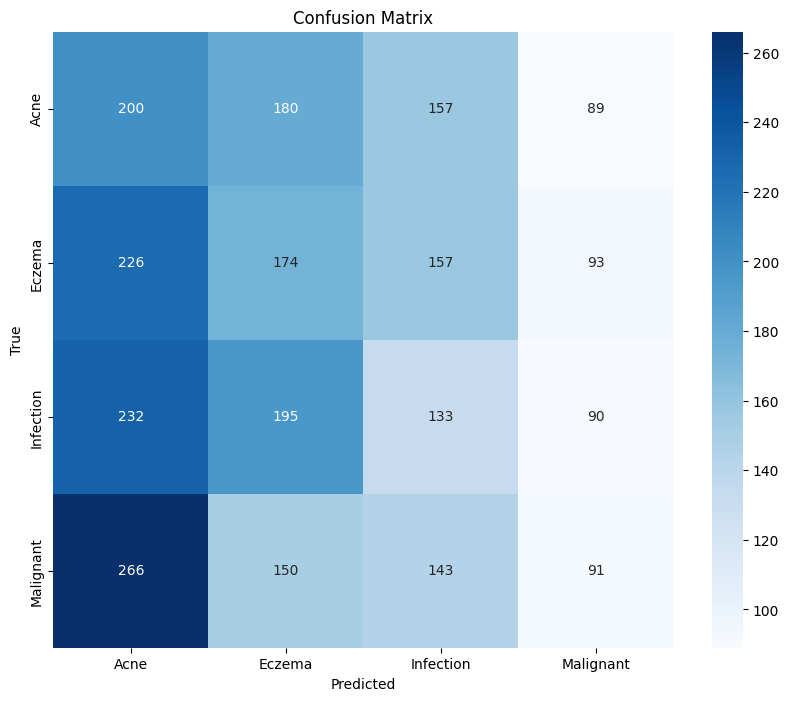

In [32]:
# Extract Features for KNN
feature_extractor = Model(inputs=base_model.input, outputs=model.layers[-3].output)  # Use the layer before the dense layer
X_train = feature_extractor.predict(train_generator, verbose=1)
y_train = train_generator.classes

X_test = feature_extractor.predict(test_generator, verbose=1)
y_test = test_generator.classes

# Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train_encoded)

# Predict and Evaluate
y_pred = knn.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels))

print("Accuracy:", accuracy_score(y_test, y_pred_labels))

# Plot Confusion Matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_labels), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 1058s 6s/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 450s 6s/step
KNN Classification Report:
              precision    recall  f1-score   support

        Acne       0.22      0.30      0.26       626
      Eczema       0.23      0.26      0.25       650
   Infection       0.22      0.19      0.20       650
   Malignant       0.16      0.11      0.13       650

    accuracy                           0.21      2576
   macro avg       0.21      0.21      0.21      2576
weighted avg       0.21      0.21      0.21      2576

Confusion Matrix:
[[188 148 146 144]
 [187 169 166 128]
 [238 192 123  97]
 [226 217 136  71]]
Accuracy: 0.2138975155279503


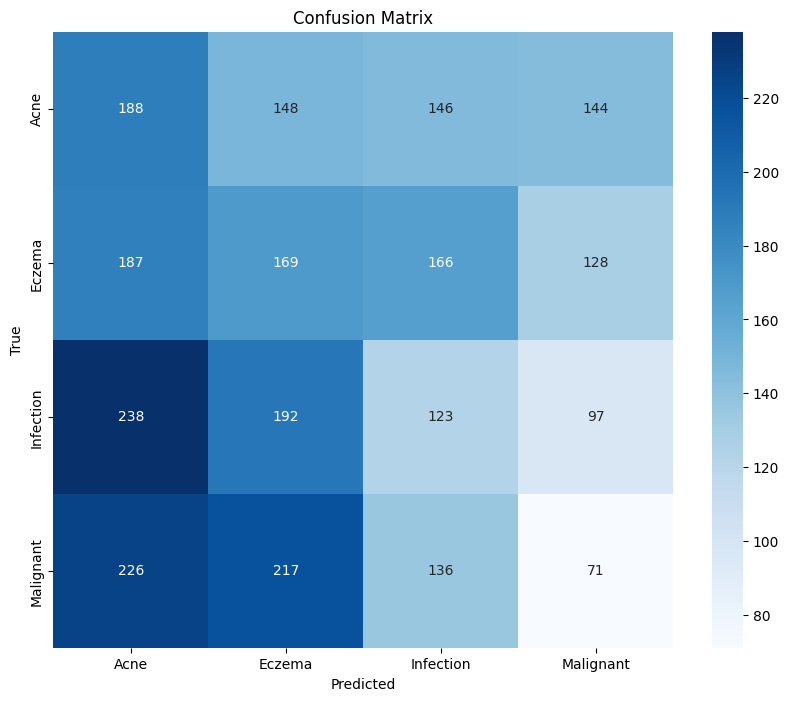

In [42]:
import joblib
from sklearn.preprocessing import StandardScaler
# Feature Extraction
feature_extractor = Model(inputs=base_model.input, outputs=model.layers[-3].output)
X_train = feature_extractor.predict(train_generator, verbose=1)
y_train = train_generator.classes

X_test = feature_extractor.predict(test_generator, verbose=1)
y_test = test_generator.classes

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train_encoded)

# Save Model
joblib.dump(knn, '../../models/hybrid_knn_model.pkl')
joblib.dump(label_encoder, '../../models/hybrid_label_encoder.pkl')
joblib.dump(scaler, '../../models/hybrid_scaler.pkl')

# Predict and Evaluate
y_pred = knn.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels))

print("Accuracy:", accuracy_score(y_test, y_pred_labels))

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_labels), annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train_encoded)
print("Best Parameters:", grid_search.best_params_)


In [ ]:
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

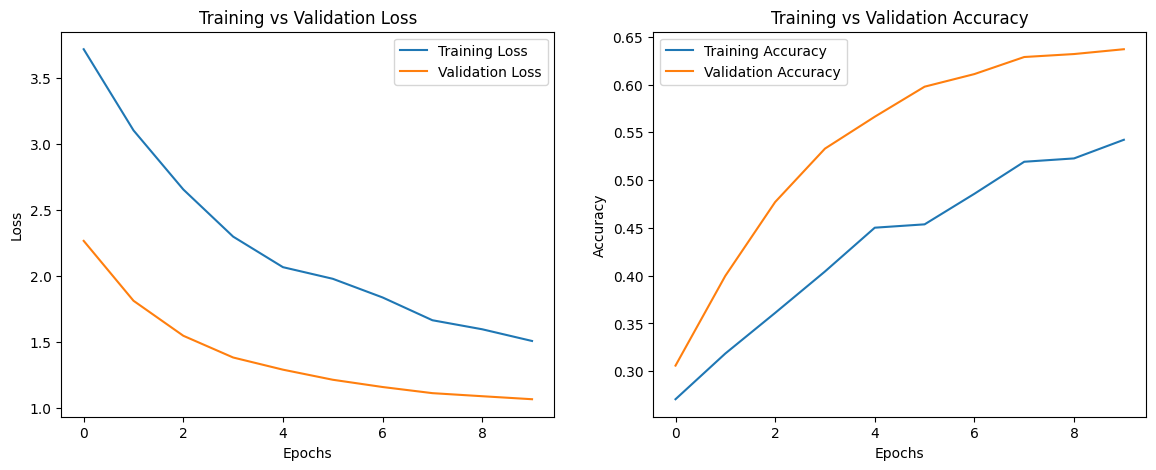

In [33]:
train_loss = history.history['loss']
train_acc  = history.history['accuracy']
val_loss   = history.history['val_loss']
val_acc    = history.history['val_accuracy']

epochs_range = range(len(train_loss))

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss,   label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc,   label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [34]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Test Loss: 0.5085420608520508
Test Accuracy: 0.8105590343475342


In [35]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


Train Loss: 0.30892133712768555
Train Accuracy: 0.8891481757164001


81/81 ━━━━━━━━━━━━━━━━━━━━ 452s 6s/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.91      0.89      0.90       626
      Eczema       0.72      0.79      0.75       650
   Infection       0.70      0.69      0.70       650
   Malignant       0.94      0.87      0.90       650

    accuracy                           0.81      2576
   macro avg       0.82      0.81      0.81      2576
weighted avg       0.82      0.81      0.81      2576

Confusion Matrix:
[[559  26  34   7]
 [ 16 515 106  13]
 [ 33 148 451  18]
 [  7  28  52 563]]


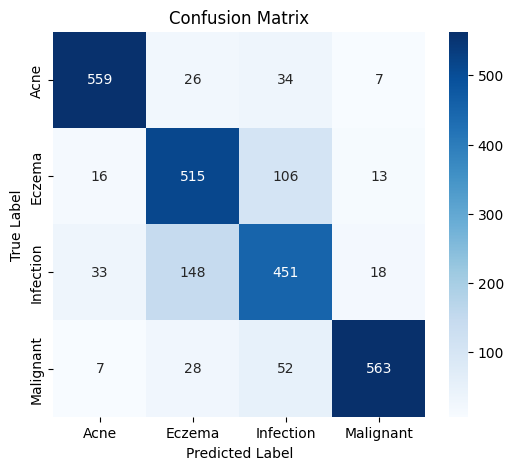

In [36]:
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the test generator
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [37]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Val Loss:", test_loss)
print("Val Accuracy:", test_accuracy)

81/81 ━━━━━━━━━━━━━━━━━━━━ 454s 6s/step - accuracy: 0.8452 - loss: 0.4614
Val Loss: 0.5085420608520508
Val Accuracy: 0.8105590343475342


Macro-average ROC AUC: 0.9529460172614304
Micro-average ROC AUC: 0.9592564858528477


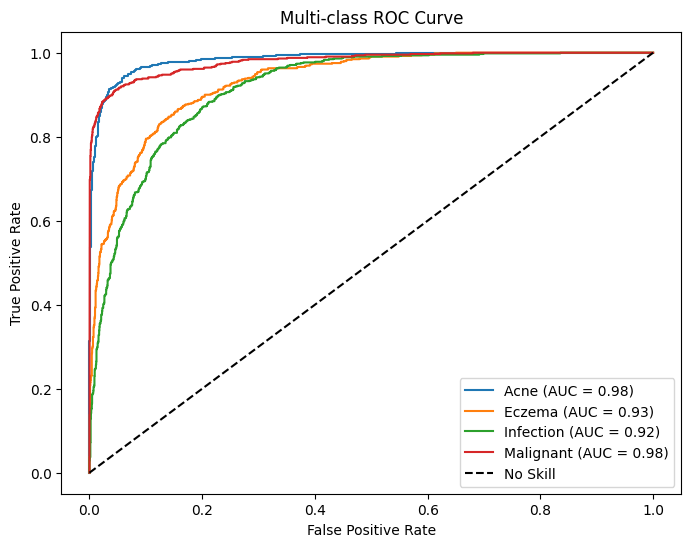

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
y_true_indices = test_generator.classes

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [41]:
model.save("../../models/hybrid_model_vgg16_knn.keras")

In [43]:
from sklearn.ensemble import RandomForestClassifier
import pickle
# Step 3: Extract Features
features = []
labels = []
for batch_images, batch_labels in train_generator:
    features.append(base_model.predict(batch_images))
    labels.append(batch_labels)
    if len(features) * BATCH_SIZE >= train_generator.samples:
        break

features = np.vstack(features)
labels = np.vstack(labels)


# Step 4: Train Random Forest Classifier
labels = np.argmax(labels, axis=1)  # Convert one-hot to integer labels
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Step 5: Evaluate Model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save Model
with open('../../models/hybrid_knn_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━

NameError: name 'GridSearchCV' is not defined

In [45]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Flatten the data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid Search with Random Forest
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_flat, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate on test data
accuracy = best_rf.score(X_test_flat, y_test)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.8166666666666667


In [48]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pickle

# Constants
BATCH_SIZE = 32  # Replace with your actual batch size
MODEL_SAVE_PATH = '../../models/hybrid_rf_vgg16_model.pkl'  # Path to save the model

# Step 1: Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        features.append(base_model.predict(batch_images))  # Extract features
        labels.append(batch_labels)
        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break
    features = np.vstack(features)  # Stack features vertically
    labels = np.vstack(labels)      # Stack labels vertically
    return features, labels

# Extract features and labels from the training data
print("Extracting features and labels...")
features, labels = extract_features_and_labels(train_generator, base_model, BATCH_SIZE)

# Convert one-hot encoded labels to integers
labels = np.argmax(labels, axis=1)

# Step 2: Split Data
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Step 3: Define and Train Random Forest with Grid Search
print("Training Random Forest with Grid Search...")
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Flatten the data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid Search with Random Forest
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_flat, y_train)

# Get the best model from grid search
best_rf = grid_search.best_estimator_

# Step 4: Evaluate the Model
print("Evaluating the model...")
y_pred = best_rf.predict(X_test_flat)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 5: Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")


Extracting features and labels...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s

ValueError: Found array with dim 4. RandomForestClassifier expected <= 2.

In [49]:
# Step 4: Evaluate the Model
print("Evaluating the model...")
y_pred = best_rf.predict(X_test_flat)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 5: Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")

Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       441
           1       0.77      0.78      0.77       456
           2       0.72      0.71      0.71       445
           3       0.97      0.88      0.92       458

    accuracy                           0.82      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.82      0.82      0.82      1800

Confusion Matrix:
[[400   9  29   3]
 [ 35 355  58   8]
 [ 43  83 317   2]
 [  3  15  39 401]]
Saving the model to ../../models/hybrid_rf_vgg16_model.pkl...
Model saved successfully.
